In [3]:
## Libraries:

# a) Bond graphs
import BondGraphTools as bgt

# b) Data extraction
from pyomexmeta import RDF, eUriType
import os
import sys
import xml.etree.ElementTree as ET
import rdflib
from lxml import etree
import re

# c) General
import copy
import difflib
import numpy as np
import pandas as pd
import math
import operator as op
import ast
import re

# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams


# Integration and fitting
from scipy.optimize import curve_fit, minimize, least_squares, newton_krylov, basinhopping
from scipy  import integrate
import scipy.stats as stats



In [68]:
data=pd.read_csv('RasGTP_module_data.csv') 
Data={}
cellmlKinetics={}
labels=[]
for label in data:
    labels.append(label)
    Data[label]=[] 
    Data[label].append(data[label])
# labels for cellml kinetics
for label in labels:
    for cell in Data[label]:
        cellmlKinetics[label]=[]  
        for c in cell:
            cellmlKinetics[label].append(c)
time= cellmlKinetics['environment | time (minute)']

In [69]:
k12=0.0163
kn12=10

#irreversible
k13=15

k14=0.005
kn14=60

#irreversible
k15=720

k16=0.0012
kn16=3

trueValues = [k12,kn12,k13,k14,kn14,k15,k16,kn16]
rowM=['r12','r13','r14','r15','r16','ShcGS','RasGDP','Ras_ShcGS','RasGTP','GAP','Ras_GAP','Ras_Raf']

M = np.zeros([len(trueValues),len(rowM)])  


In [70]:
# k12=r12*K_RasGDP*K_ShcGS
M[0][0]=1
M[0][5]=1
M[0][6]=1

# kn12=r12*K_Ras_ShcGS
M[1][0]=1
M[1][7]=1

# k13=r_13*K_Ras_ShcGS
M[2][1]=1
M[2][7]=1

# k14=r14*K_RasGTP*K_GAP
M[3][2]=1
M[3][8]=1
M[3][9]=1

# kn14=r14*K_Ras_GAP
M[4][2]=1
M[4][10]=1

# k15=r15*K_Ras_GAP
M[5][3]=1
M[5][10]=1

# k16=r16*K_RasGTP
M[6][4]=1
M[6][8]=1


# kn16=r16*K_Ras_Raf
M[7][4]=1
M[7][11]=1

logTrueValues = [];

for k in trueValues:
    logTrueValues.append(math.log(k))

logTrueValues = np.array(logTrueValues)


Mpinv = np.linalg.pinv(np.array(M))
logU = Mpinv.dot(logTrueValues)

thermodynamics = [math.exp(i) for i in list(logU)]
for i in range(len(thermodynamics)):
        print(rowM[i],' ==> ',thermodynamics[i])

r12  ==>  0.9549941838101605
r13  ==>  1.432491275715242
r14  ==>  1.40422462980177
r15  ==>  16.850695557621247
r16  ==>  0.18663263259944843
ShcGS  ==>  0.130645194234795
RasGDP  ==>  0.13064519423479512
Ras_ShcGS  ==>  10.471267961133337
RasGTP  ==>  0.006429743733913092
GAP  ==>  0.5537831716241434
Ras_GAP  ==>  42.72820653236212
Ras_Raf  ==>  16.0743593347826


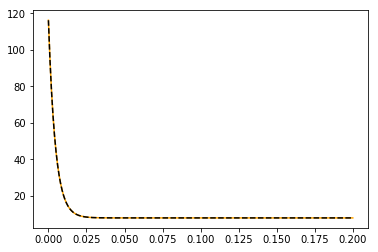

In [71]:
# v12 = r12*(K_RasGDP*K_ShcGS*X_RasGDP*X_ShcGS - K_Ras_ShcGS*X_Ras_ShcGS)

v12=thermodynamics[0]*(thermodynamics[6]*thermodynamics[5]*np.array(cellmlKinetics['RasGDP | RasGDP (dimensionless)'])*np.array(cellmlKinetics['ShcGS | ShcGS (dimensionless)']) - \
                       thermodynamics[7]*np.array(cellmlKinetics['Ras_ShcGS | Ras_ShcGS (dimensionless)']))


plt.plot(time[0:-800],cellmlKinetics['v12 | v12 (first_order_rate_constant)'][0:-800],'orange')
plt.plot(time[0:-800],v12[0:-800],'k--')

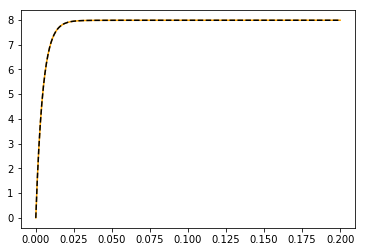

In [83]:
# v13 = r13*(K_Ras_ShcGS*X_Ras_ShcGS - 1e-9*K_RasGTP*X_RasGTP*K_ShcGS*X_ShcGS)

v13=thermodynamics[1]*(thermodynamics[7]*np.array(cellmlKinetics['Ras_ShcGS | Ras_ShcGS (dimensionless)'])- \
                       1e-9*thermodynamics[8]*np.array(cellmlKinetics['RasGTP | RasGTP (dimensionless)'])**thermodynamics[5]*np.array(cellmlKinetics['ShcGS | ShcGS (dimensionless)']))

plt.plot(time[0:-800],cellmlKinetics['v13 | v13 (first_order_rate_constant)'][0:-800], 'orange')
plt.plot(time[0:-800],v13[0:-800],'k--')

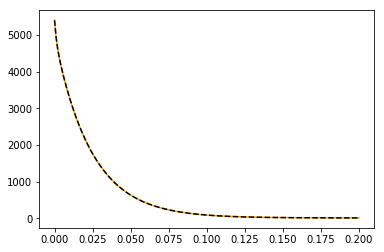

In [81]:
# v14 = r14*(K_RasGTP*K_GAP*X_RasGTP*X_GAP - K_Ras_GAP*X_Ras_GAP)

v14=thermodynamics[2]*(thermodynamics[8]*thermodynamics[9]*np.array(cellmlKinetics['RasGTP | RasGTP (dimensionless)'])*np.array(cellmlKinetics['GAP | GAP (dimensionless)']) -\
                      thermodynamics[10]*np.array(cellmlKinetics['Ras_GAP | Ras_GAP (dimensionless)']))

plt.plot(time[0:-800],cellmlKinetics['v14 | v14 (first_order_rate_constant)'][0:-800],'orange')
plt.plot(time[0:-800],v14[0:-800],'k--')

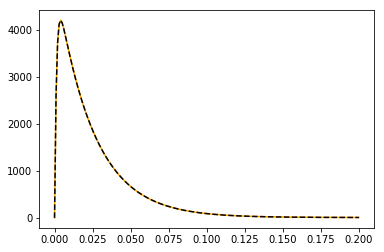

In [82]:
# v15 = r15*(K_Ras_GAP*X_Ras_GAP - 1e-9*K_GAP*K_RasGDP*X_GAP*X_RasGDP)

v15=thermodynamics[3]*(thermodynamics[10]*np.array(cellmlKinetics['Ras_GAP | Ras_GAP (dimensionless)'])-\
                       1e-9*thermodynamics[9]*np.array(cellmlKinetics['GAP | GAP (dimensionless)'])*thermodynamics[6]*np.array(cellmlKinetics['RasGDP | RasGDP (dimensionless)']))

plt.plot(time[0:-800],cellmlKinetics['v15 | v15 (first_order_rate_constant)'][0:-800], 'orange')
plt.plot(time[0:-800],v15[0:-800],'k--')

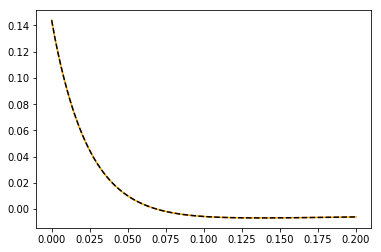

In [75]:
# v16 = r16*(K_RasGTP*X_RasGTP - K_Ras_Raf*X_Ras_Raf)

v16=thermodynamics[4]*(thermodynamics[8]*np.array(cellmlKinetics['RasGTP | RasGTP (dimensionless)']) -\
                      thermodynamics[11]*np.array(cellmlKinetics['Ras_Raf | Ras_Raf (dimensionless)']))

plt.plot(time[0:-800],cellmlKinetics['v16 | v16 (first_order_rate_constant)'][0:-800],'orange')
plt.plot(time[0:-800],v16[0:-800],'k--')